In [1]:
import gc, os, random, pickle
import pandas as pd
import numpy as np
import scipy
from scipy import stats

# 导入模型和sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score,auc, log_loss
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 200)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
    
'''seaborn and matplotlib'''
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

'''plotly'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

'''按markdown格式展现数据'''
init_notebook_mode(connected = True)
from IPython.display import Markdown

def bold(string):
    display(Markdown(string))

/Users/baixiaoling/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# EDA

In [2]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test =pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

In [3]:
print(train.shape, test.shape)

(1134555, 9) (537949, 8)


In [4]:
train.head(2)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label
0,17a0a1f19a7f43558cb9cca517b6e198,21,-288.512,0.30256,1.83962,289.066,17.7811,410e86bc0457482d9d6f81cd2d95ccf0,1
1,36d1005f56d343d5a09513cb7a4ead61,26,-158.448,2.13265,-16.28340,159.718,11.5848,6f7bf9104f8c4a619eedd129d5ce3dcb,5


In [5]:
test.head(2)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id
0,cb3b5c6ea5e441e9b425fc1e6a4a00e6,23,-86.9773,0.268724,6.699850,87.5486,7.39969,63d5670e5c514f00b64c0329382af524
1,838bf5c3f9bc4a2194f51b3c57f403cd,26,72.0487,-7.242040,-0.515331,73.2549,11.06970,8ddc9b4f189d42d08bde2936914341ed


In [6]:
print(train['label'].value_counts())
# 21 多一点外，其他几类基本上差不多

21    358600
1     261207
4     260186
5     254562
Name: label, dtype: int64


In [7]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134555 entries, 0 to 1134554
Data columns (total 9 columns):
jet_id                             1134555 non-null object
number_of_particles_in_this_jet    1134555 non-null int64
jet_px                             1134555 non-null float64
jet_py                             1134555 non-null float64
jet_pz                             1134555 non-null float64
jet_energy                         1134555 non-null float64
jet_mass                           1134555 non-null float64
event_id                           1134555 non-null object
label                              1134555 non-null int64
dtypes: float64(5), int64(2), object(2)
memory usage: 77.9+ MB


In [8]:
# 缺失值分析
# all_missing_columns = train.columns[train.isnull().sum() == train.shape[0]]
train.isnull().sum() # 没有缺失值

jet_id                             0
number_of_particles_in_this_jet    0
jet_px                             0
jet_py                             0
jet_pz                             0
jet_energy                         0
jet_mass                           0
event_id                           0
label                              0
dtype: int64

In [9]:
onlyone_val_columns = train.columns[train.nunique(axis=0) == 1]

print('共有 %i 个特征列仅仅只包含一个元素之，' % len(onlyone_val_columns))

print('这些特征列为: ',onlyone_val_columns )

共有 0 个特征列仅仅只包含一个元素之，
这些特征列为:  Index([], dtype='object')


In [133]:
train.describe()

,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,label
count,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06
mean,2.141576e+01,-1.262110e-02,9.496788e-04,1.830779e-03,1.592155e+02,1.357930e+01,8.906894e+00
std,1.226341e+01,2.025569e+02,2.944280e+01,2.802875e+01,1.328982e+02,1.205523e+01,8.340469e+00
min,1.000000e+00,-4.984470e+02,-4.160350e+02,-4.270560e+02,1.004080e+01,-5.642010e-06,1.000000e+00
25%,1.200000e+01,-1.072530e+02,-5.802830e+00,-5.108620e+00,4.049085e+01,4.959175e+00,4.000000e+00
50%,1.900000e+01,1.473780e-01,-1.807420e-03,1.853660e-03,1.198290e+02,1.007730e+01,5.000000e+00
75%,2.800000e+01,1.071365e+02,5.820565e+00,5.157565e+00,2.574340e+02,1.802500e+01,2.100000e+01
max,1.090000e+02,4.987270e+02,4.383140e+02,3.900830e+02,5.003970e+02,1.171720e+02,2.100000e+01


In [134]:
def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
train[train['jet_mass'] < 0].shape # 共有652个值 质量为负， 可以填充为0 或者直接删除
# test[train['jet_mass'] < 0].shape #
train['jet_mass']  = train['jet_mass'].map(lambda x : replace(x))
train['jet_energy']  = train['jet_energy'].map(lambda x : replace(x))

In [135]:
train[train['jet_mass'] < 0].head(100)
# train.head(2)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label


In [136]:
train.loc[train['jet_mass'] < 0]= 0 

In [137]:
train[train['label'] <= 0].head()

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label


In [138]:
train[train['jet_mass'] < 0]['label'].value_counts() # 各个类别都有


Series([], Name: label, dtype: int64)

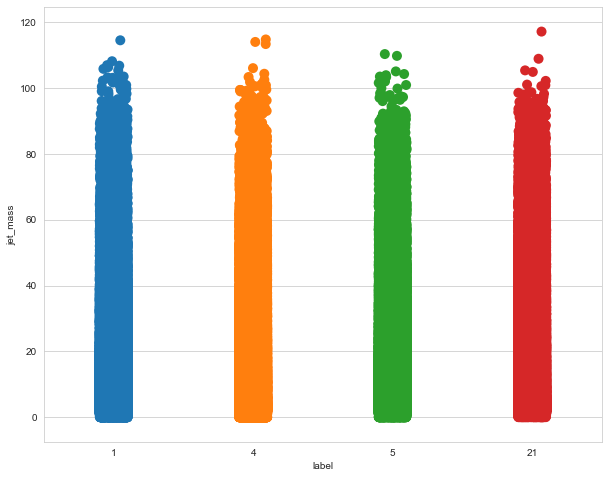

In [139]:
sns.stripplot(x = 'label', y='jet_mass', data =train,size =10,jitter =True )

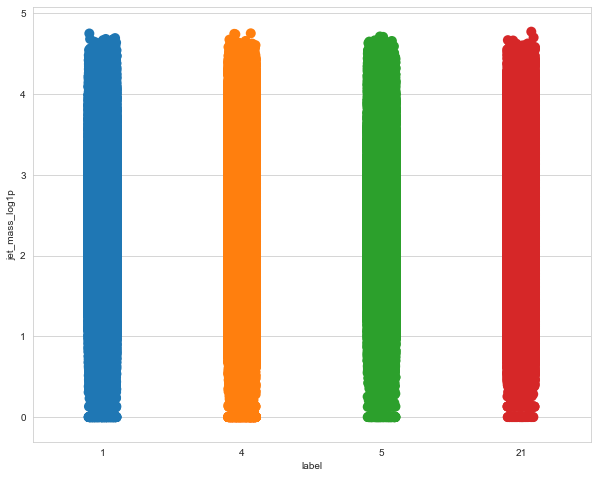

In [140]:
train['jet_mass_log1p'] =  train['jet_mass'].map(lambda x: np.log1p(x))
sns.stripplot(x = 'label', y='jet_mass_log1p', data =train,size =10,jitter =True )

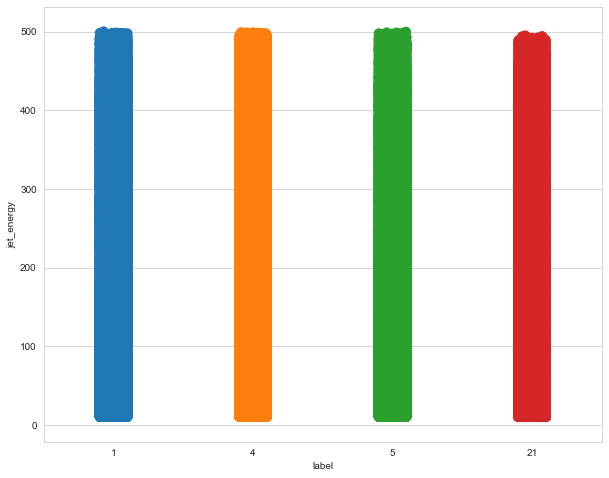

In [141]:
sns.stripplot(x = 'label', y='jet_energy', data =train,size =10,jitter =True )

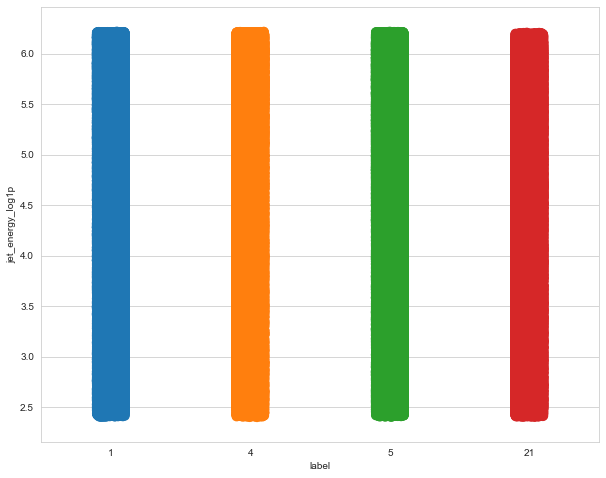

In [142]:
train['jet_energy_log1p'] =  train['jet_energy'].map(lambda x: np.log1p(x))
sns.stripplot(x = 'label', y='jet_energy_log1p', data =train,size =10,jitter =True )

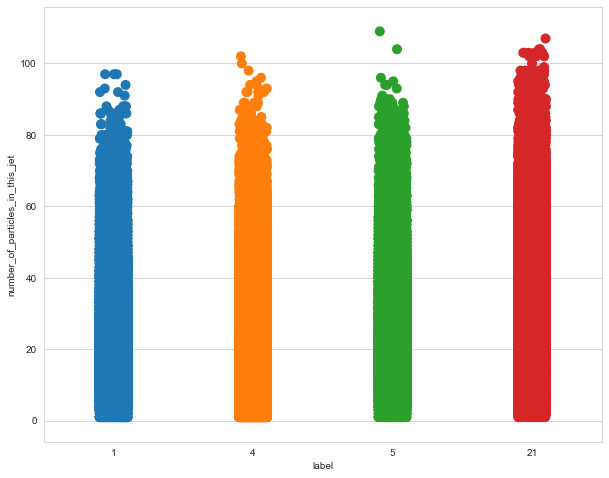

In [143]:
sns.stripplot(x = 'label', y='number_of_particles_in_this_jet', data =train,size =10,jitter =True )

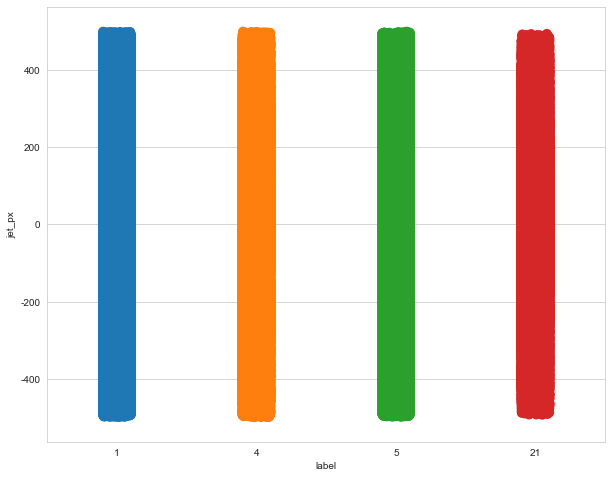

In [144]:
sns.stripplot(x = 'label', y='jet_px', data =train,size =10, jitter =True ) # 没啥区分度


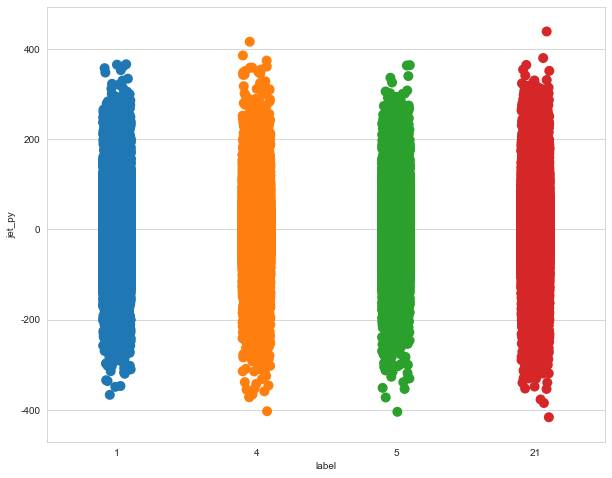

In [145]:
sns.stripplot(x = 'label', y='jet_py', data =train,size =10, jitter =True )


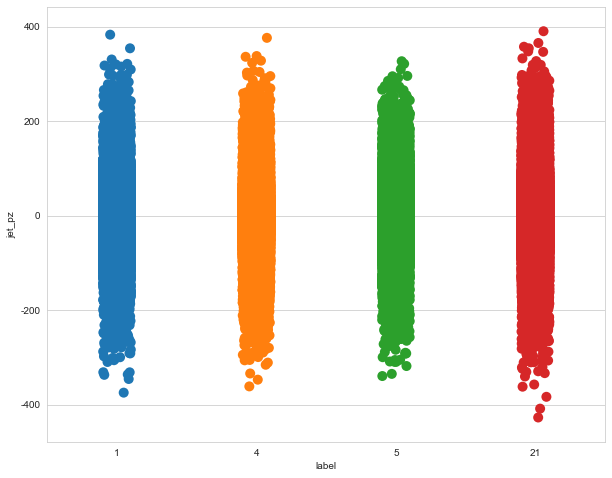

In [146]:
sns.stripplot(x = 'label', y='jet_pz', data =train,size =10, jitter =True )

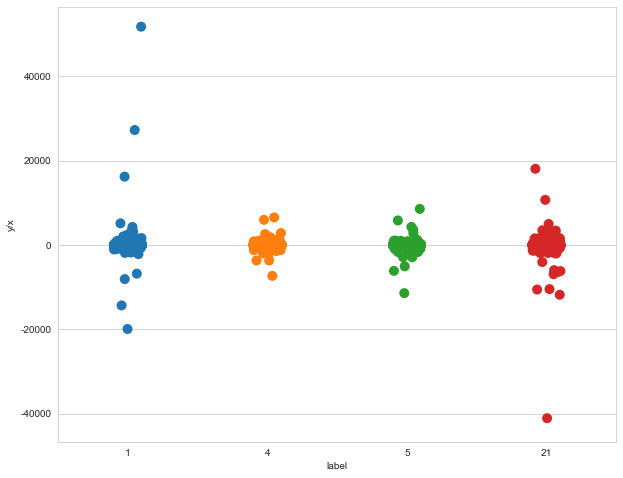

In [147]:
train['y/x'] = train['jet_py'] / train['jet_px']
sns.stripplot(x = 'label', y='y/x', data =train,size =10, jitter =True )

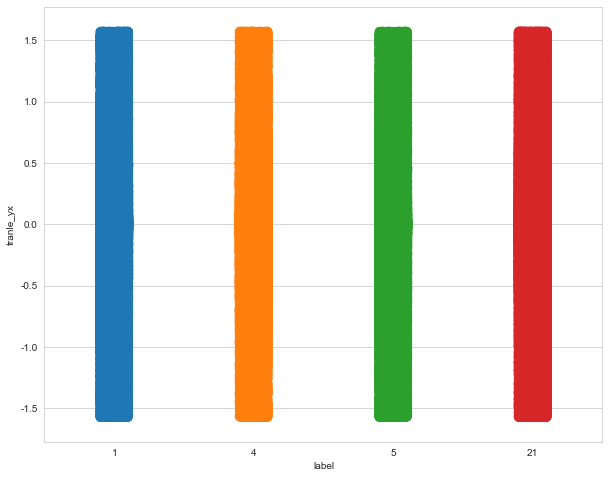

In [148]:
import math
train['tranle_yx'] = train['y/x'].map(lambda x : math.atan(x))
sns.stripplot(x = 'label', y='tranle_yx', data =train,size =10, jitter =True ) # 角度 没多大用

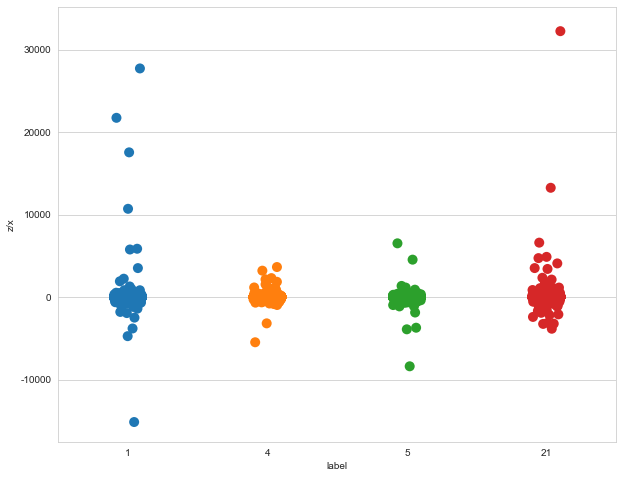

In [149]:
train['z/x'] = train['jet_pz'] / train['jet_px']
sns.stripplot(x = 'label', y='z/x', data =train,size =10, jitter =True )

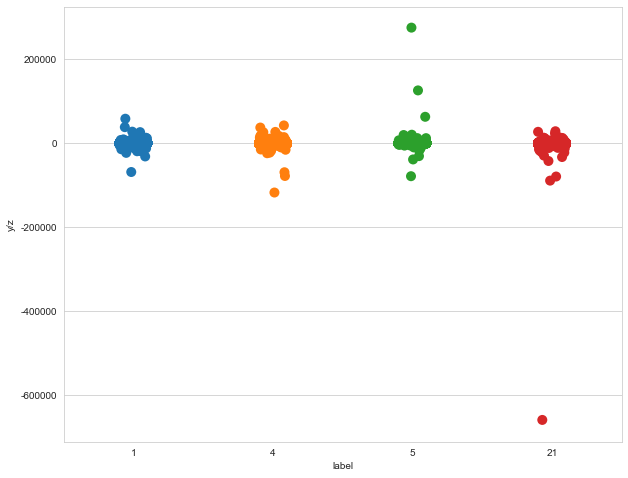

In [150]:
train['y/z'] = train['jet_py'] / train['jet_pz']
sns.stripplot(x = 'label', y='y/z', data =train,size =10, jitter =True )

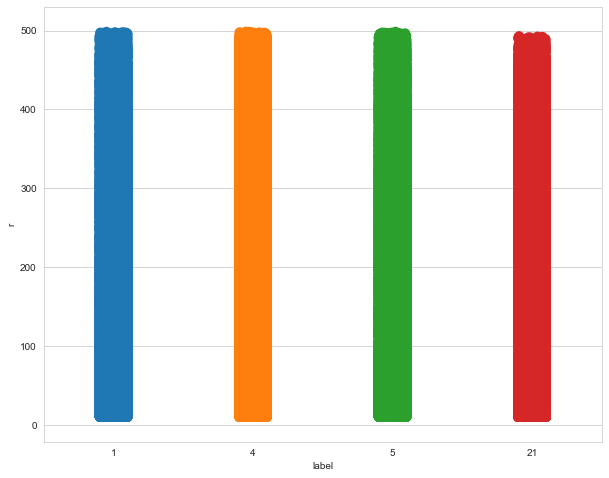

In [151]:
train['r'] = (train['jet_px'] * train['jet_px']  + train['jet_py'] * train['jet_py'] + train['jet_pz'] * train['jet_pz'])**0.5
sns.stripplot(x = 'label', y='r', data =train,size =10, jitter =True )
# 没啥区分度

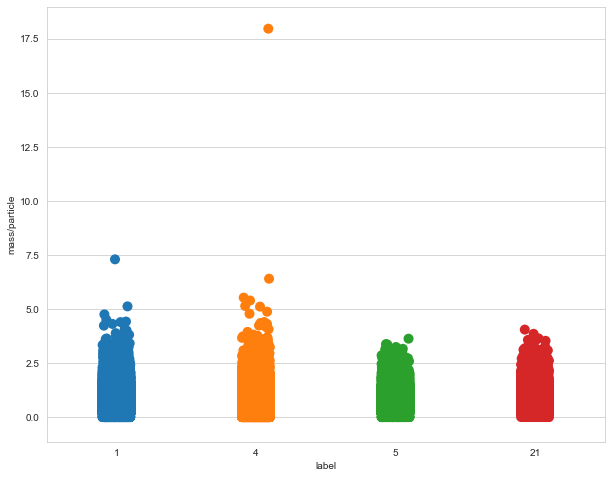

In [152]:
#jet_id	number_of_particles_in_this_jet	jet_px	jet_py	jet_pz	jet_energy	jet_mass	
train['mass/particle'] =train['jet_mass'] / train['number_of_particles_in_this_jet']
sns.stripplot(x = 'label', y='mass/particle', data =train,size =10, jitter =True )


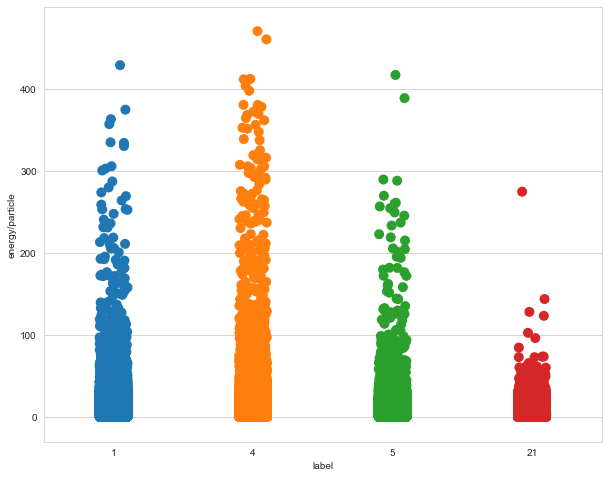

In [153]:
train['energy/particle'] =train['jet_energy'] / train['number_of_particles_in_this_jet']
sns.stripplot(x = 'label', y='energy/particle', data =train,size =10, jitter =True )

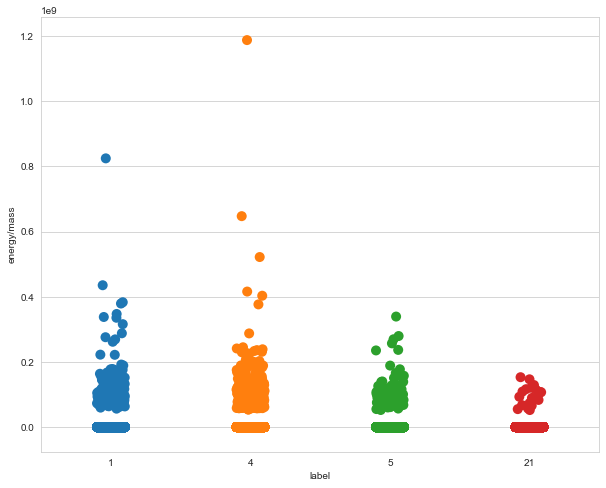

In [154]:
train['energy/mass'] =train['jet_energy'] / train['jet_mass']

sns.stripplot(x = 'label', y='energy/mass', data =train,size =10, jitter =True )

In [155]:
evnet_jetnum_data = pd.DataFrame({"event_jet_num":train.groupby('event_id')['jet_id'].count()})
train = train.merge(evnet_jetnum_data, on='event_id', how='left')


evnet_jetmass_data = pd.DataFrame(
    {
    "event_jetmass_max":train.groupby('event_id')['jet_mass'].max(), 
     "event_jetmass_min":train.groupby('event_id')['jet_mass'].min(), 
    'event_jetmass_region': train.groupby('event_id')['jet_mass'].max() - train.groupby('event_id')['jet_mass'].min(), 
     "event_jetmass_std":train.groupby('event_id')['jet_mass'].std(), 
     "event_jetmass_mean":train.groupby('event_id')['jet_mass'].mean()
    }
)

train = train.merge(evnet_jetmass_data, on='event_id', how='left')

In [156]:
train.head(30)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label,jet_mass_log1p,jet_energy_log1p,y/x,tranle_yx,z/x,y/z,r,mass/particle,energy/particle,energy/mass,event_jet_num,event_jetmass_max,event_jetmass_min,event_jetmass_region,event_jetmass_std,event_jetmass_mean
0,17a0a1f19a7f43558cb9cca517b6e198,21,-288.51200,0.302560,1.839620,289.0660,17.78110,410e86bc0457482d9d6f81cd2d95ccf0,1,2.932851,5.670108,-0.001049,-0.001049,-0.006376,0.164469,288.518024,0.846719,13.765048,16.256924,2,17.78110,12.98130,4.79980,3.393971,15.381200
1,36d1005f56d343d5a09513cb7a4ead61,26,-158.44800,2.132650,-16.283400,159.7180,11.58480,6f7bf9104f8c4a619eedd129d5ce3dcb,5,2.532490,5.079651,-0.013460,-0.013459,0.102768,-0.130971,159.296786,0.445569,6.143000,13.786859,2,15.38960,11.58480,3.80480,2.690400,13.487200
2,a82071a653304481979b5dfb8eb0da47,27,-104.14300,-37.267200,-20.658500,113.3200,13.42170,4ee694b125c944c1a4560a20b79ccbe3,4,2.668734,4.739002,0.357846,0.343648,0.198367,1.803964,112.522808,0.497100,4.197037,8.443044,4,15.63180,4.13042,11.50138,5.437937,9.972905
3,d3b2474fe3ba43e2b02b918adf8bbd98,17,284.80900,1.313630,0.562324,286.0620,26.71040,a0543408ffe140979e03b063fd7129c5,1,3.321808,5.659698,0.004612,0.004612,0.001974,2.336073,284.812585,1.571200,16.827176,10.709761,2,26.71040,10.66480,16.04560,11.345953,18.687600
4,e46253f34c93428cb91fe0c7fc03c430,12,-38.30670,15.601100,-7.581700,42.2007,3.55142,a4b2679fd14a418c8d21fcaf2e32be8e,4,1.515439,3.765857,-0.407268,-0.386756,0.197921,-2.057731,42.050919,0.295952,3.516725,11.882768,3,21.56420,3.55142,18.01278,9.615293,10.613690
5,b4ca1bcf4b9c4aedbb500f21adb398a8,33,-277.75100,-17.075500,-51.440200,283.2630,12.44620,fce3d18f6c6841fe9715909f6aac3ef1,4,2.598697,5.649900,0.061478,0.061400,0.185203,0.331949,282.989902,0.377158,8.583727,22.758995,3,12.44620,5.25338,7.19282,3.596413,8.847027
6,8440698de493402c987a6eb4dec04fbb,7,6.81748,9.607290,12.590500,17.3225,1.66464,1dec0f8b271b48db818cd42906897e87,21,0.980069,2.908130,1.409214,0.953646,1.846797,0.763059,17.242353,0.237806,2.474643,10.406154,4,19.24430,1.66464,17.57966,7.418977,11.768335
7,927925b32db84240861b7e6bb2ff2f0b,15,249.66200,0.884765,1.114080,250.0910,14.57460,50d011feb97d43c9b5eb99d49a14d016,1,2.745641,5.525815,0.003544,0.003544,0.004462,0.794166,249.666053,0.971640,16.672733,17.159373,2,16.18830,14.57460,1.61370,1.141058,15.381450
8,625710d07b7b4e7780f51766c2f4da50,32,-354.18200,-17.528200,-12.137400,356.5820,35.38130,c2e82ff9287041248290c1f721b96c68,1,3.594055,5.879365,0.049489,0.049449,0.034269,1.444148,354.823116,1.105666,11.143187,10.078262,4,35.38130,6.54789,28.83341,13.841282,14.828130
9,d032bb93386d4ecdac77ec7bdd6bcda2,18,316.81000,0.003403,-2.918050,317.0110,10.90910,877e7da50a9940338f3abac2c9f710f5,5,2.477303,5.762086,0.000011,0.000011,-0.009211,-0.001166,316.823438,0.606061,17.611722,29.059317,2,14.39650,10.90910,3.48740,2.465964,12.652800


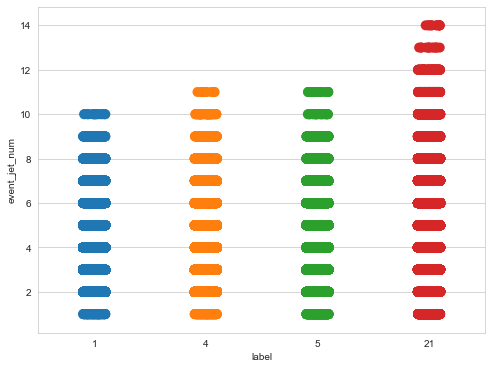

In [183]:
plt.rcParams['figure.figsize'] = (8,6)
sns.stripplot(x = 'label', y='event_jet_num', data =train,size =10, jitter =True )
# 强特征，有用

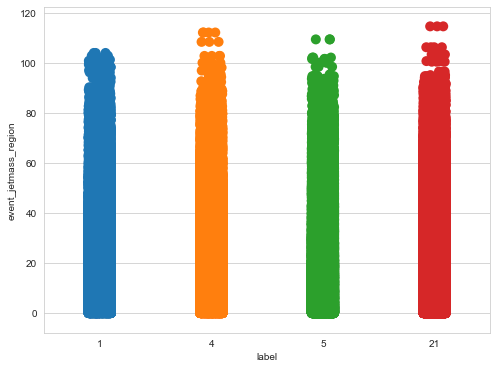

In [184]:
plt.rcParams['figure.figsize'] = (8,6)
sns.stripplot(x = 'label', y='event_jetmass_region', data =train,size =10, jitter =True )


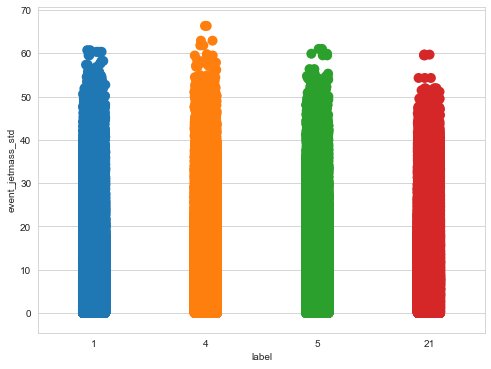

In [185]:
plt.rcParams['figure.figsize'] = (8,6)
sns.stripplot(x = 'label', y='event_jetmass_std', data =train,size =10, jitter =True )

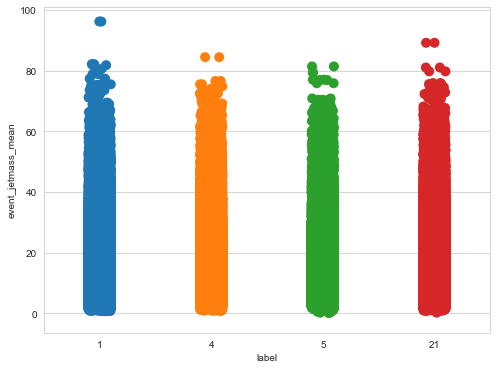

In [186]:
sns.stripplot(x = 'label', y='event_jetmass_mean', data =train,size =10, jitter =True )

In [193]:

evnet_jetmass_data = pd.DataFrame(
    {
    "event_jet_energy_max":train.groupby('event_id')['jet_energy'].max(), 
     "event_jet_energy_min":train.groupby('event_id')['jet_energy'].min(), 
    'event_jet_energy_region': train.groupby('event_id')['jet_energy'].max() - train.groupby('event_id')['jet_energy'].min(), 
     "event_jet_energy_std":train.groupby('event_id')['jet_energy'].std(), 
     "event_jet_energy_mean":train.groupby('event_id')['jet_energy'].mean()
    }
)

train = train.merge(evnet_jetmass_data, on='event_id', how='left')

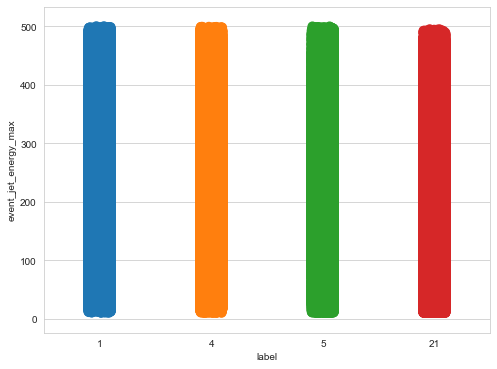

In [194]:
plt.rcParams['figure.figsize'] = (8,6)
sns.stripplot(x = 'label', y='event_jet_energy_max', data =train,size =10, jitter =True )

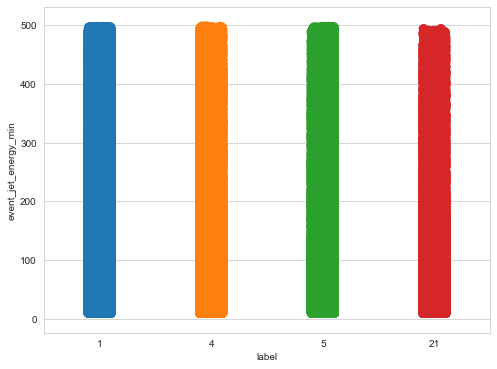

In [195]:
plt.rcParams['figure.figsize'] = (8,6)
sns.stripplot(x = 'label', y='event_jet_energy_min', data =train,size =10, jitter =True )

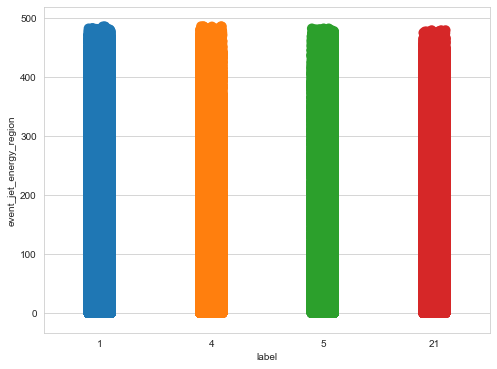

In [196]:
plt.rcParams['figure.figsize'] = (8,6)
sns.stripplot(x = 'label', y='event_jet_energy_region', data =train,size =10, jitter =True )

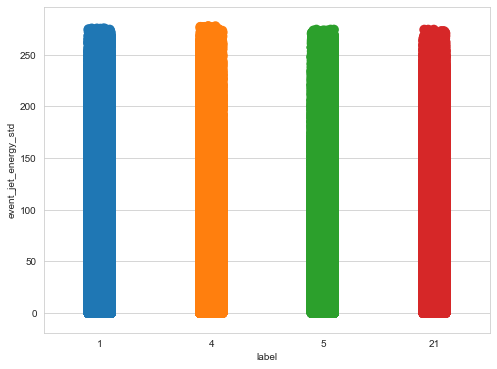

In [197]:
plt.rcParams['figure.figsize'] = (8,6)
sns.stripplot(x = 'label', y='event_jet_energy_std', data =train,size =10, jitter =True )

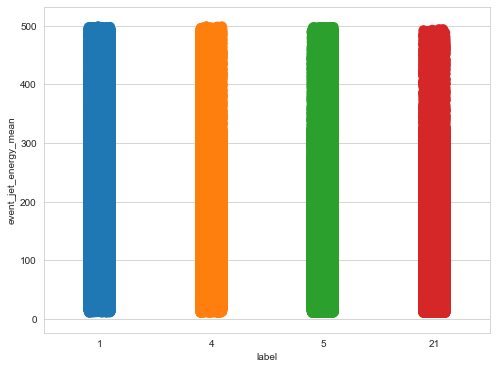

In [198]:
plt.rcParams['figure.figsize'] = (8,6)
sns.stripplot(x = 'label', y='event_jet_energy_mean', data =train,size =10, jitter =True )

In [199]:
# 根据坐标求方位

def get_direction(px, py, pz):
#     print(px, py, pz)
    if px > 0:
        if py > 0:
            if pz > 0:
                return 1
            else:
                return 2
        else:
            if pz > 0:
                return 3
            else:
                return 4
    else:
        if py > 0:
            if pz > 0:
                return 5
            else:
                return 6
        else:
            if pz > 0:
                return 7
            else:
                return 8
train['jet_direction'] = train.apply(lambda x : get_direction(x.jet_px, x.jet_py, x.jet_pz), axis=1)

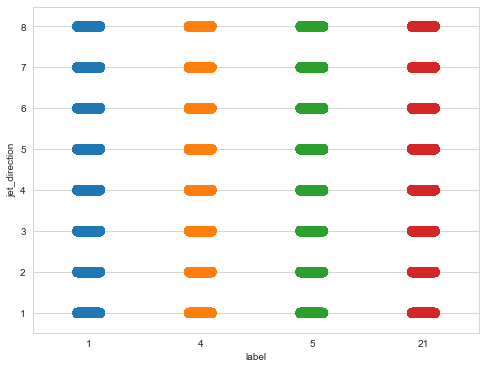

In [200]:
plt.rcParams['figure.figsize'] = (8,6)
sns.stripplot(x = 'label', y='jet_direction', data =train,size =10, jitter =True )

In [201]:
train.head()

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label,jet_mass_log1p,jet_energy_log1p,y/x,tranle_yx,z/x,y/z,r,mass/particle,energy/particle,energy/mass,event_jet_num,event_jetmass_max,event_jetmass_min,event_jetmass_region,event_jetmass_std,event_jetmass_mean,event_px_max,event_px_min,event_py_max,event_py_min,event_pz_max,event_pz_min,jet_direction,event_tiji,event_jet_energy_max,event_jet_energy_min,event_jet_energy_region,event_jet_energy_std,event_jet_energy_mean
0,17a0a1f19a7f43558cb9cca517b6e198,21,-288.5120,0.30256,1.839620,289.0660,17.78110,410e86bc0457482d9d6f81cd2d95ccf0,1,2.932851,5.670108,-0.001049,-0.001049,-0.006376,0.164469,288.518024,0.846719,13.765048,16.256924,2,17.7811,12.98130,4.79980,3.393971,15.381200,297.769,-288.512,0.44249,0.302560,1.83962,-8.106470,5,815.960319,298.162,289.0660,9.0960,6.431843,293.614000
1,36d1005f56d343d5a09513cb7a4ead61,26,-158.4480,2.13265,-16.283400,159.7180,11.58480,6f7bf9104f8c4a619eedd129d5ce3dcb,5,2.532490,5.079651,-0.013460,-0.013459,0.102768,-0.130971,159.296786,0.445569,6.143000,13.786859,2,15.3896,11.58480,3.80480,2.690400,13.487200,147.791,-158.448,2.13265,-8.945790,7.76439,-16.283400,6,81585.744054,159.718,149.0620,10.6560,7.534930,154.390000
2,a82071a653304481979b5dfb8eb0da47,27,-104.1430,-37.26720,-20.658500,113.3200,13.42170,4ee694b125c944c1a4560a20b79ccbe3,4,2.668734,4.739002,0.357846,0.343648,0.198367,1.803964,112.522808,0.497100,4.197037,8.443044,4,15.6318,4.13042,11.50138,5.437937,9.972905,180.710,-104.143,22.43980,-37.267200,21.24280,-20.658500,8,712645.497208,181.448,35.5493,145.8987,64.323257,98.016750
3,d3b2474fe3ba43e2b02b918adf8bbd98,17,284.8090,1.31363,0.562324,286.0620,26.71040,a0543408ffe140979e03b063fd7129c5,1,3.321808,5.659698,0.004612,0.004612,0.001974,2.336073,284.812585,1.571200,16.827176,10.709761,2,26.7104,10.66480,16.04560,11.345953,18.687600,284.809,-279.211,1.31363,0.524126,3.79034,0.562324,1,1437.422761,286.062,279.4410,6.6210,4.681754,282.751500
4,e46253f34c93428cb91fe0c7fc03c430,12,-38.3067,15.60110,-7.581700,42.2007,3.55142,a4b2679fd14a418c8d21fcaf2e32be8e,4,1.515439,3.765857,-0.407268,-0.386756,0.197921,-2.057731,42.050919,0.295952,3.516725,11.882768,3,21.5642,3.55142,18.01278,9.615293,10.613690,291.576,-260.876,15.60110,-16.492600,8.19955,-7.581700,6,279805.172499,292.395,42.2007,250.1943,136.434186,198.735567


In [202]:
# 求事件的体积
evnet_tiji_data = pd.DataFrame(
    {
    "event_px_max":train.groupby('event_id')['jet_px'].max(), 
    "event_px_min":train.groupby('event_id')['jet_px'].min(), 
    "event_py_max": train.groupby('event_id')['jet_py'].max() , 
    "event_py_min": train.groupby('event_id')['jet_py'].min() , 
    "event_pz_max": train.groupby('event_id')['jet_pz'].max() , 
    "event_pz_min": train.groupby('event_id')['jet_pz'].min() , 
    }
)

train = train.merge(evnet_tiji_data, on='event_id', how='left')

In [203]:
train.head()

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label,jet_mass_log1p,jet_energy_log1p,y/x,tranle_yx,z/x,y/z,r,mass/particle,energy/particle,energy/mass,event_jet_num,event_jetmass_max,event_jetmass_min,event_jetmass_region,event_jetmass_std,event_jetmass_mean,event_px_max_x,event_px_min_x,event_py_max_x,event_py_min_x,event_pz_max_x,event_pz_min_x,jet_direction,event_tiji,event_jet_energy_max,event_jet_energy_min,event_jet_energy_region,event_jet_energy_std,event_jet_energy_mean,event_px_max_y,event_px_min_y,event_py_max_y,event_py_min_y,event_pz_max_y,event_pz_min_y
0,17a0a1f19a7f43558cb9cca517b6e198,21,-288.5120,0.30256,1.839620,289.0660,17.78110,410e86bc0457482d9d6f81cd2d95ccf0,1,2.932851,5.670108,-0.001049,-0.001049,-0.006376,0.164469,288.518024,0.846719,13.765048,16.256924,2,17.7811,12.98130,4.79980,3.393971,15.381200,297.769,-288.512,0.44249,0.302560,1.83962,-8.106470,5,815.960319,298.162,289.0660,9.0960,6.431843,293.614000,297.769,-288.512,0.44249,0.302560,1.83962,-8.106470
1,36d1005f56d343d5a09513cb7a4ead61,26,-158.4480,2.13265,-16.283400,159.7180,11.58480,6f7bf9104f8c4a619eedd129d5ce3dcb,5,2.532490,5.079651,-0.013460,-0.013459,0.102768,-0.130971,159.296786,0.445569,6.143000,13.786859,2,15.3896,11.58480,3.80480,2.690400,13.487200,147.791,-158.448,2.13265,-8.945790,7.76439,-16.283400,6,81585.744054,159.718,149.0620,10.6560,7.534930,154.390000,147.791,-158.448,2.13265,-8.945790,7.76439,-16.283400
2,a82071a653304481979b5dfb8eb0da47,27,-104.1430,-37.26720,-20.658500,113.3200,13.42170,4ee694b125c944c1a4560a20b79ccbe3,4,2.668734,4.739002,0.357846,0.343648,0.198367,1.803964,112.522808,0.497100,4.197037,8.443044,4,15.6318,4.13042,11.50138,5.437937,9.972905,180.710,-104.143,22.43980,-37.267200,21.24280,-20.658500,8,712645.497208,181.448,35.5493,145.8987,64.323257,98.016750,180.710,-104.143,22.43980,-37.267200,21.24280,-20.658500
3,d3b2474fe3ba43e2b02b918adf8bbd98,17,284.8090,1.31363,0.562324,286.0620,26.71040,a0543408ffe140979e03b063fd7129c5,1,3.321808,5.659698,0.004612,0.004612,0.001974,2.336073,284.812585,1.571200,16.827176,10.709761,2,26.7104,10.66480,16.04560,11.345953,18.687600,284.809,-279.211,1.31363,0.524126,3.79034,0.562324,1,1437.422761,286.062,279.4410,6.6210,4.681754,282.751500,284.809,-279.211,1.31363,0.524126,3.79034,0.562324
4,e46253f34c93428cb91fe0c7fc03c430,12,-38.3067,15.60110,-7.581700,42.2007,3.55142,a4b2679fd14a418c8d21fcaf2e32be8e,4,1.515439,3.765857,-0.407268,-0.386756,0.197921,-2.057731,42.050919,0.295952,3.516725,11.882768,3,21.5642,3.55142,18.01278,9.615293,10.613690,291.576,-260.876,15.60110,-16.492600,8.19955,-7.581700,6,279805.172499,292.395,42.2007,250.1943,136.434186,198.735567,291.576,-260.876,15.60110,-16.492600,8.19955,-7.581700


In [205]:
def get_tiji(x, y, z) :
    return x* y * z
train['event_tiji'] = train.apply(lambda x : get_tiji(x.event_px_max - x.event_px_min, x.event_py_max - x.event_py_min, x.event_pz_max - x.event_pz_min), axis=1)

AttributeError: ("'Series' object has no attribute 'event_px_max'", 'occurred at index 0')

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
sns.stripplot(x = 'label', y='event_tiji', data =train, size =10, jitter =True )

In [ ]:
# 散点图
plt.rcParams['figure.figsize'] = (8,6)
train.plot.scatter(x='jet_mass', y='jet_energy', alpha=0.3, ylim=(0,300));

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
train.plot.scatter(x='number_of_particles_in_this_jet', y='jet_energy', alpha=0.3, ylim=(0,300));

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
train.plot.scatter(x='number_of_particles_in_this_jet', y='jet_mass', alpha=0.3, ylim=(0,100));

In [ ]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0, 
            square=True, cmap='RdBu') #cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

In [ ]:
# 箱线图
f, ax = plt.subplots(figsize=(6, 4))
fig = sns.boxplot(x=train['label'], y="jet_energy", data=train)
fig.axis(ymin=0, ymax=200);

In [ ]:
# 箱线图
f, ax = plt.subplots(figsize=(6, 4))
fig = sns.boxplot(x=train['label'], y="jet_mass", data=train)
fig.axis(ymin=0, ymax=200);

In [210]:

del train, test
gc.collect()

16392

# 特征工程

## 加载数据 & 减少内存占用



In [30]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test= pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')


# def reduce_mem_usage(df):
#     '''迭代所有列，减少内存使用'''
#     start_mem = df.memory_usage().sum() / (1024**2)
#     print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
#     for col in df.columns:
#         col_type = df[col].dtype
        
#         if col_type != object:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

#     end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
#     return df


# reduce_mem_usage(train)
# reduce_mem_usage(test)

In [31]:
data = train.append(test)
data.shape

(1672504, 9)

In [32]:
def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

data['jet_mass']  = data['jet_mass'].map(lambda x : replace(x))
data['jet_energy']  = data['jet_energy'].map(lambda x : replace(x))
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

(977, 9) (0, 9)
(0, 9) (0, 9)


In [33]:
data.head()

,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet
0,410e86bc0457482d9d6f81cd2d95ccf0,289.0660,17a0a1f19a7f43558cb9cca517b6e198,17.78110,-288.5120,0.30256,1.839620,1.0,21
1,6f7bf9104f8c4a619eedd129d5ce3dcb,159.7180,36d1005f56d343d5a09513cb7a4ead61,11.58480,-158.4480,2.13265,-16.283400,5.0,26
2,4ee694b125c944c1a4560a20b79ccbe3,113.3200,a82071a653304481979b5dfb8eb0da47,13.42170,-104.1430,-37.26720,-20.658500,4.0,27
3,a0543408ffe140979e03b063fd7129c5,286.0620,d3b2474fe3ba43e2b02b918adf8bbd98,26.71040,284.8090,1.31363,0.562324,1.0,17
4,a4b2679fd14a418c8d21fcaf2e32be8e,42.2007,e46253f34c93428cb91fe0c7fc03c430,3.55142,-38.3067,15.60110,-7.581700,4.0,12


In [34]:
# 根据坐标求方位

def get_direction(px, py, pz):
#     print(px, py, pz)
    if px > 0:
        if py > 0:
            if pz > 0:
                return 1
            else:
                return 2
        else:
            if pz > 0:
                return 3
            else:
                return 4
    else:
        if py > 0:
            if pz > 0:
                return 5
            else:
                return 6
        else:
            if pz > 0:
                return 7
            else:
                return 8

def get_feature(data_):
    
    # 能方向特征
    data = data_.copy()
    data['y/x'] = data['jet_py']/ data['jet_px']
    data['z/x'] = data['jet_pz']/ data['jet_px']
    data['y/z'] = data['jet_py']/ data['jet_pz']
    data['r'] = (data['jet_px'] * data['jet_px']  + data['jet_py'] * data['jet_py'] + data['jet_pz'] * data['jet_pz'])**0.5
    # 方位
    data['jet_direction'] = data.apply(lambda x : get_direction(x.jet_px, x.jet_py, x.jet_pz), axis=1)
    
    # 单粒子mass、energy，energy/mass
    data['mass/particle'] =data['jet_mass'] / data['number_of_particles_in_this_jet']
    data['energy/particle'] =data['jet_energy'] / data['number_of_particles_in_this_jet']
    data['energy/mass'] =data['jet_energy'] / data['jet_mass']
    
    # event 统计特征
    evnet_jetnum_data = pd.DataFrame({"event_jet_num": data.groupby('event_id')['jet_id'].count()})
    data = data.merge(evnet_jetnum_data, on='event_id', how='left')
    # event-mass
    evnet_jetmass_data = pd.DataFrame({
        "event_jetmass_max":data.groupby('event_id')['jet_mass'].max(), 
        "event_jetmass_min":data.groupby('event_id')['jet_mass'].min(), 
        "event_jetmass_region": data.groupby('event_id')['jet_mass'].max() - data.groupby('event_id')['jet_mass'].min(), 
        "event_jetmass_std":data.groupby('event_id')['jet_mass'].std(), 
        "event_jetmass_mean":data.groupby('event_id')['jet_mass'].mean()
        }
    )
    
    data = data.merge(evnet_jetmass_data, on='event_id', how='left')
    
    # event-energy
    evnet_jetenergy_data = pd.DataFrame(
        {
        "event_jet_energy_max": data.groupby('event_id')['jet_energy'].max(), 
        "event_jet_energy_min": data.groupby('event_id')['jet_energy'].min(), 
        "event_jet_energy_region": data.groupby('event_id')['jet_energy'].max() - data.groupby('event_id')['jet_energy'].min(), 
        "event_jet_energy_std": data.groupby('event_id')['jet_energy'].std(), 
        "event_jet_energy_mean": data.groupby('event_id')['jet_energy'].mean()
        }
    )

    data = data.merge(evnet_jetenergy_data, on='event_id', how='left')
    

    # 求事件的体积
    evnet_tiji_data = pd.DataFrame(
        {
        "event_px_max":data.groupby('event_id')['jet_px'].max(), 
        "event_px_min":data.groupby('event_id')['jet_px'].min(), 
        "event_px_region":data.groupby('event_id')['jet_px'].max() - data.groupby('event_id')['jet_px'].min(), 
            
        "event_py_max": data.groupby('event_id')['jet_py'].max() , 
        "event_py_min": data.groupby('event_id')['jet_py'].min() , 
        "event_py_region":data.groupby('event_id')['jet_py'].max() - data.groupby('event_id')['jet_py'].min(), 
            
        "event_pz_max": data.groupby('event_id')['jet_pz'].max() , 
        "event_pz_min": data.groupby('event_id')['jet_pz'].min() , 
        "event_pz_region":data.groupby('event_id')['jet_pz'].max() - data.groupby('event_id')['jet_pz'].min(), 
        }
    )

    data = data.merge(evnet_tiji_data, on='event_id', how='left')
    def get_tiji(x, y, z) :
        return x* y * z
    data['event_tiji'] = data.apply(lambda x : get_tiji(x.event_px_region, x.event_py_region, x.event_pz_region), axis=1)
    
    return data
    
    

In [35]:
data_new = get_feature(data)

In [36]:
print(data_new.shape)
data_new.head()

(1672504, 38)


,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet,y/x,z/x,y/z,r,jet_direction,mass/particle,energy/particle,energy/mass,event_jet_num,event_jetmass_max,event_jetmass_min,event_jetmass_region,event_jetmass_std,event_jetmass_mean,event_jet_energy_max,event_jet_energy_min,event_jet_energy_region,event_jet_energy_std,event_jet_energy_mean,event_px_max,event_px_min,event_px_region,event_py_max,event_py_min,event_py_region,event_pz_max,event_pz_min,event_pz_region,event_tiji
0,410e86bc0457482d9d6f81cd2d95ccf0,289.0660,17a0a1f19a7f43558cb9cca517b6e198,17.78110,-288.5120,0.30256,1.839620,1.0,21,-0.001049,-0.006376,0.164469,288.518024,5,0.846719,13.765048,16.256924,2,17.7811,12.98130,4.79980,3.393971,15.381200,298.162,289.0660,9.0960,6.431843,293.614000,297.769,-288.512,586.281,0.44249,0.302560,0.139930,1.83962,-8.106470,9.946090,815.960319
1,6f7bf9104f8c4a619eedd129d5ce3dcb,159.7180,36d1005f56d343d5a09513cb7a4ead61,11.58480,-158.4480,2.13265,-16.283400,5.0,26,-0.013460,0.102768,-0.130971,159.296786,6,0.445569,6.143000,13.786859,2,15.3896,11.58480,3.80480,2.690400,13.487200,159.718,149.0620,10.6560,7.534930,154.390000,147.791,-158.448,306.239,2.13265,-8.945790,11.078440,7.76439,-16.283400,24.047790,81585.744054
2,4ee694b125c944c1a4560a20b79ccbe3,113.3200,a82071a653304481979b5dfb8eb0da47,13.42170,-104.1430,-37.26720,-20.658500,4.0,27,0.357846,0.198367,1.803964,112.522808,8,0.497100,4.197037,8.443044,4,15.6318,4.13042,11.50138,5.437937,9.972905,181.448,35.5493,145.8987,64.323257,98.016750,180.710,-104.143,284.853,22.43980,-37.267200,59.707000,21.24280,-20.658500,41.901300,712645.497208
3,a0543408ffe140979e03b063fd7129c5,286.0620,d3b2474fe3ba43e2b02b918adf8bbd98,26.71040,284.8090,1.31363,0.562324,1.0,17,0.004612,0.001974,2.336073,284.812585,1,1.571200,16.827176,10.709761,2,26.7104,10.66480,16.04560,11.345953,18.687600,286.062,279.4410,6.6210,4.681754,282.751500,284.809,-279.211,564.020,1.31363,0.524126,0.789504,3.79034,0.562324,3.228016,1437.422761
4,a4b2679fd14a418c8d21fcaf2e32be8e,42.2007,e46253f34c93428cb91fe0c7fc03c430,3.55142,-38.3067,15.60110,-7.581700,4.0,12,-0.407268,0.197921,-2.057731,42.050919,6,0.295952,3.516725,11.882768,3,21.5642,3.55142,18.01278,9.615293,10.613690,292.395,42.2007,250.1943,136.434186,198.735567,291.576,-260.876,552.452,15.60110,-16.492600,32.093700,8.19955,-7.581700,15.781250,279805.172499


In [37]:
data_new.columns

Index(['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py',
       'jet_pz', 'label', 'number_of_particles_in_this_jet', 'y/x', 'z/x',
       'y/z', 'r', 'jet_direction', 'mass/particle', 'energy/particle',
       'energy/mass', 'event_jet_num', 'event_jetmass_max',
       'event_jetmass_min', 'event_jetmass_region', 'event_jetmass_std',
       'event_jetmass_mean', 'event_jet_energy_max', 'event_jet_energy_min',
       'event_jet_energy_region', 'event_jet_energy_std',
       'event_jet_energy_mean', 'event_px_max', 'event_px_min',
       'event_px_region', 'event_py_max', 'event_py_min', 'event_py_region',
       'event_pz_max', 'event_pz_min', 'event_pz_region', 'event_tiji'],
      dtype='object')

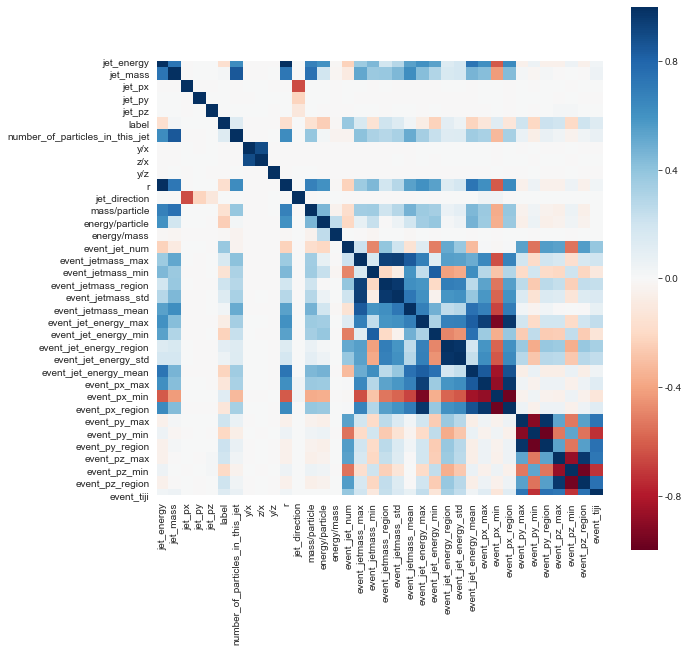

In [38]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(data_new.corr(), vmin=-1, vmax=1, center=0, 
            square=True, cmap='RdBu') #cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

# 模型训练

In [39]:
tr_index = ~data_new['label'].isnull()
train = data_new[tr_index].reset_index(drop=True)
y = data_new[tr_index]['label'].reset_index(drop=True).astype(int)
test = data_new[~tr_index].reset_index(drop=True)
print(train.shape,test.shape)

(1134555, 38) (537949, 38)


In [40]:
from sklearn.preprocessing import LabelEncoder
object_col = ['label']
for i in tqdm(object_col):
    lbl = LabelEncoder()
    train[i] = lbl.fit_transform(train[i].astype(str))

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


In [41]:
train.head()

,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet,y/x,z/x,y/z,r,jet_direction,mass/particle,energy/particle,energy/mass,event_jet_num,event_jetmass_max,event_jetmass_min,event_jetmass_region,event_jetmass_std,event_jetmass_mean,event_jet_energy_max,event_jet_energy_min,event_jet_energy_region,event_jet_energy_std,event_jet_energy_mean,event_px_max,event_px_min,event_px_region,event_py_max,event_py_min,event_py_region,event_pz_max,event_pz_min,event_pz_region,event_tiji
0,410e86bc0457482d9d6f81cd2d95ccf0,289.0660,17a0a1f19a7f43558cb9cca517b6e198,17.78110,-288.5120,0.30256,1.839620,0,21,-0.001049,-0.006376,0.164469,288.518024,5,0.846719,13.765048,16.256924,2,17.7811,12.98130,4.79980,3.393971,15.381200,298.162,289.0660,9.0960,6.431843,293.614000,297.769,-288.512,586.281,0.44249,0.302560,0.139930,1.83962,-8.106470,9.946090,815.960319
1,6f7bf9104f8c4a619eedd129d5ce3dcb,159.7180,36d1005f56d343d5a09513cb7a4ead61,11.58480,-158.4480,2.13265,-16.283400,3,26,-0.013460,0.102768,-0.130971,159.296786,6,0.445569,6.143000,13.786859,2,15.3896,11.58480,3.80480,2.690400,13.487200,159.718,149.0620,10.6560,7.534930,154.390000,147.791,-158.448,306.239,2.13265,-8.945790,11.078440,7.76439,-16.283400,24.047790,81585.744054
2,4ee694b125c944c1a4560a20b79ccbe3,113.3200,a82071a653304481979b5dfb8eb0da47,13.42170,-104.1430,-37.26720,-20.658500,2,27,0.357846,0.198367,1.803964,112.522808,8,0.497100,4.197037,8.443044,4,15.6318,4.13042,11.50138,5.437937,9.972905,181.448,35.5493,145.8987,64.323257,98.016750,180.710,-104.143,284.853,22.43980,-37.267200,59.707000,21.24280,-20.658500,41.901300,712645.497208
3,a0543408ffe140979e03b063fd7129c5,286.0620,d3b2474fe3ba43e2b02b918adf8bbd98,26.71040,284.8090,1.31363,0.562324,0,17,0.004612,0.001974,2.336073,284.812585,1,1.571200,16.827176,10.709761,2,26.7104,10.66480,16.04560,11.345953,18.687600,286.062,279.4410,6.6210,4.681754,282.751500,284.809,-279.211,564.020,1.31363,0.524126,0.789504,3.79034,0.562324,3.228016,1437.422761
4,a4b2679fd14a418c8d21fcaf2e32be8e,42.2007,e46253f34c93428cb91fe0c7fc03c430,3.55142,-38.3067,15.60110,-7.581700,2,12,-0.407268,0.197921,-2.057731,42.050919,6,0.295952,3.516725,11.882768,3,21.5642,3.55142,18.01278,9.615293,10.613690,292.395,42.2007,250.1943,136.434186,198.735567,291.576,-260.876,552.452,15.60110,-16.492600,32.093700,8.19955,-7.581700,15.781250,279805.172499


In [42]:
y.head()

0    1
1    5
2    4
3    1
4    4
Name: label, dtype: int64

In [ ]:
train_features = [ 'jet_energy', 'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'number_of_particles_in_this_jet', 
        'y/x', 'z/x', 'y/z', 'r', 'jet_direction', 'mass/particle', 'energy/particle','energy/mass', 'event_jet_num', 
        'event_jetmass_max','event_jetmass_min', 'event_jetmass_region', 'event_jetmass_std', 'event_jetmass_mean',
        'event_jet_energy_max', 'event_jet_energy_min', 'event_jet_energy_region', 'event_jet_energy_std',
        'event_jet_energy_mean', 'event_px_max', 'event_px_min',  'event_px_region', 'event_py_max', 
        'event_py_min', 'event_py_region', 'event_pz_max', 'event_pz_min', 'event_pz_region', 'event_tiji']

# train_features = ['event_jetmass_mean', 'event_jet_energy_mean', 'event_jet_num', 
#                   'number_of_particles_in_this_jet', 'event_jet_energy_region', 
#                   'event_jet_energy_std', 'jet_energy', 'event_px_region', 'event_jetmass_max', 
#                   'event_jetmass_min', 'event_px_min', 'jet_mass', 'event_px_max', 'event_pz_region', 
#                   'event_jet_energy_max', 'event_py_min', 'event_py_region', 'event_py_max', 
#                   'event_jetmass_std', 'event_jet_energy_min', 'event_pz_max', 'event_pz_min', 
#                   'event_tiji', 'event_jetmass_region']

# train_features = ['number_of_particles_in_this_jet','jet_px', 
#                   'jet_py', 'jet_pz', 'jet_energy', 'jet_mass',
#                   'particle_energy','particle_mass', 'mass_energy', 
#                   'event_id_num', ] # bestTest = 0.7071216899

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 2
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
cv_score = []
test_pred = np.zeros((test.shape[0],4))

# for index, (train_index, test_index) in tqdm(enumerate(kf.split(train, train['label']))):
#     print(index)
    
#     train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train['label'].iloc[train_index], train['label'].iloc[test_index]
train_x, test_x, train_y, test_y = train_test_split(train, train['label'], test_size=0.33, random_state=42)
model = CatBoostClassifier(
    iterations=2000 ,
    loss_function='MultiClass',
#     custom_metric=['Accuracy','AUC'],
    eval_metric = 'Accuracy',
    verbose=100,
    learning_rate=0.1, 
    max_depth=5, 
    early_stopping_rounds=50, 
)
model.fit(train_x[train_features], train_y, eval_set=(test_x[train_features], test_y))

y_pred = model.predict(test_x[train_features])

print('分类报告：\n',classification_report(test_y , y_pred))
      # 交叉验证单模型中，预测测试数据
test_pre = model.predict(test[train_features])
# print(test_pre)

cat_map  = {1:21, 0:1, 2:4, 3: 5}
out = [cat_map[x[0]] for x in test_pre]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1217-01.csv', index=False)


0:	learn: 0.4115090	test: 0.4118546	best: 0.4118546 (0)	total: 2.33s	remaining: 1h 17m 40s
100:	learn: 0.4847655	test: 0.4839238	best: 0.4839238 (100)	total: 1m 56s	remaining: 36m 37s
200:	learn: 0.4943373	test: 0.4928286	best: 0.4928286 (200)	total: 3m 26s	remaining: 30m 45s
300:	learn: 0.5001730	test: 0.4982773	best: 0.4982799 (299)	total: 5m 2s	remaining: 28m 26s
400:	learn: 0.5045050	test: 0.5013328	best: 0.5013328 (400)	total: 6m 22s	remaining: 25m 24s
500:	learn: 0.5082727	test: 0.5043322	best: 0.5043429 (498)	total: 7m 59s	remaining: 23m 53s
600:	learn: 0.5111195	test: 0.5064609	best: 0.5066532 (594)	total: 9m 45s	remaining: 22m 42s
700:	learn: 0.5135874	test: 0.5083653	best: 0.5084160 (699)	total: 11m 11s	remaining: 20m 43s
800:	learn: 0.5155884	test: 0.5098290	best: 0.5098396 (798)	total: 13m 1s	remaining: 19m 30s
900:	learn: 0.5177708	test: 0.5111350	best: 0.5111350 (900)	total: 14m 21s	remaining: 17m 30s
1000:	learn: 0.5197546	test: 0.5125399	best: 0.5125773 (987)	total: 15m

In [1]:
bold("**catboost特征重要性**")
print(model.feature_importances_)
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
feature_important = dict(zip(train_features, model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print(feature_important)


feature_import_usefull = [key for (key, value) in feature_important if value > 1.5]

print("\n\n catboost 重要性 > 1.5 特征类别：", len(feature_import_usefull),  feature_import_usefull)



NameError: name 'bold' is not defined